<table width='100%'>
<tr>
<td style='background-color:white'>
    <p align="left">
    Exercises for the course<br>
        <b>Deep Learning 1</b><br>
    Winter Semester 2022/23
    </p>
</td>
<td style='background-color:white'>
    Machine Learning Group<br>
    <b>Faculty IV – Electrical Engineering and Computer Science</b><br>
    Technische Universität Berlin
</td>
</tr>
</table>

<br>
<center>
    <h1>Exercise Sheet 7 (programming part)</h1>
</center>
<br>

In this homework, our goal is to try out recurrent neural network layers in PyTorch.

## Part 1: Visualizing the data


Because gradient computation can be error-prone, we often rely on libraries that incorporate automatic differentiation. In this exercise, we make use of the PyTorch library. You are then asked to compute the error of the neural network within that framework, which will then be automatically differentiated.

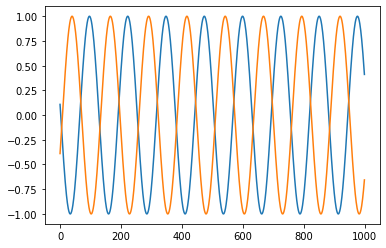

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import utils07 as utils

# 1. Get the data and parameters
data = utils.getdata()

# 2. Visualize the time series
plt.plot(data.T)

input = torch.from_numpy(data[:, :-1])
target = torch.from_numpy(data[:, 1:])


In [2]:
print(input.shape)
print(target.shape)

torch.Size([2, 999])
torch.Size([2, 999])


## Part 2: Implementing a LSTM Network (15 P)

Implement a two layer LSTM network with pytorch.nn.LSTMCell with 25 hidden neurons.
At each prediction step use a linear projection layer to project the hidden representation back to the original data space.

In [3]:
class LSTM_Network(nn.Module):
    def __init__(self):
        super().__init__()  # implement two LSTMCell layers  # and one linear projection layer
        self.lstm_1 = nn.LSTMCell(1,25)
        self.lstm_2 = nn.LSTMCell(25, 25)
        self.fc = nn.Linear(25, 1)

    def forward(self, input, prediction_steps=0):
        # Compute the LSTM's predictions over the input
        h_t = torch.zeros(input.size(0), 25, dtype=torch.double)
        c_t = torch.zeros(input.size(0), 25, dtype=torch.double)
        h_t2 = torch.zeros(input.size(0), 25, dtype=torch.double)
        c_t2 = torch.zeros(input.size(0), 25, dtype=torch.double)
        outputs = []
        
        for input_t in input.split(1, dim=1):
            h_t, c_t = self.lstm_1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm_2(h_t, (h_t2, c_t2))
            output = self.fc(h_t2)
            outputs += [output]
            
        for i in range(prediction_steps):
            h_t, c_t = self.lstm_1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm_2(h_t, (h_t2, c_t2))
            output = self.fc(h_t2)
            outputs += [output]
        outputs = torch.cat(outputs, dim=1)
        # Compute 'prediction_steps' steps of predictions into the future
        # Return the concatenated outputs
        return outputs

lstm = LSTM_Network()

## Part 3: Train the LSTM and Visualize It (15P)

As the final part you tasked with implementing the necessary steps of training the previously implemented LSTM.
It should return the `loss` variable which will be backpropagated through time by the autograd engine of PyTorch.
The training setup is already fixed for you.

In [4]:
from torch import optim

lstm.double()
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm.parameters())
num_steps = 100
for i in range(num_steps):
    optimizer.zero_grad()
    outputs = lstm(input)
    loss = criterion(outputs, target)
    loss.backward()
    optimizer.step()
    
    if i % (num_steps//10) == 0:
        print(f'Training Progress: {int(i/num_steps*100)}%, Loss:', loss.item())

with torch.no_grad():
    future = 100
    pred = lstm(input, prediction_steps=future)
    y = pred.detach().numpy()

Training Progress: 0%, Loss: 0.5162734432792001
Training Progress: 10%, Loss: 0.4792666991720813
Training Progress: 20%, Loss: 0.4264617772052427
Training Progress: 30%, Loss: 0.2999899450281277
Training Progress: 40%, Loss: 0.09461630641339813
Training Progress: 50%, Loss: 0.08111997979344664
Training Progress: 60%, Loss: 0.060813245733834315
Training Progress: 70%, Loss: 0.04356099541343149
Training Progress: 80%, Loss: 0.03425356839571869
Training Progress: 90%, Loss: 0.026660691487243083


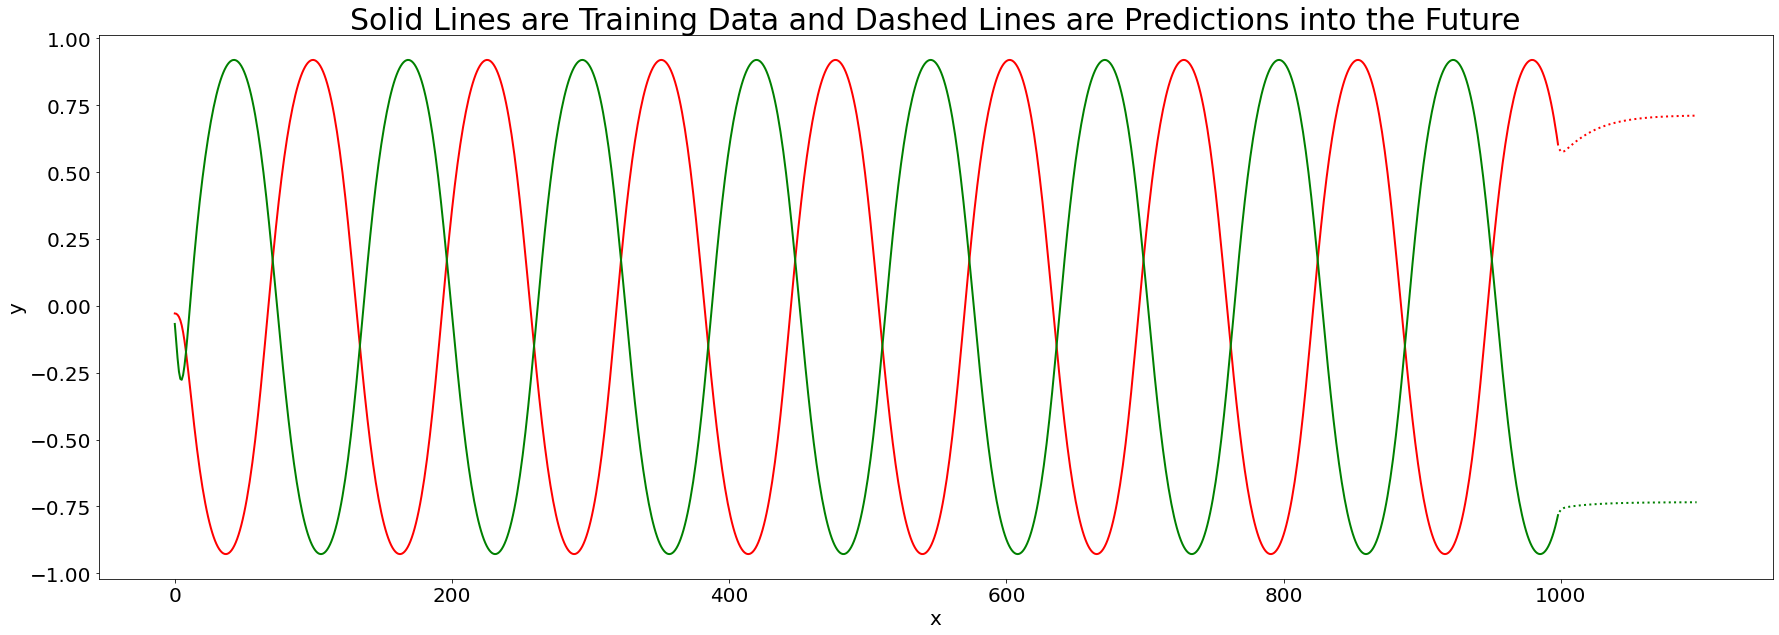

In [5]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(30, 10))
plt.title('Solid Lines are Training Data and Dashed Lines are Predictions into the Future', fontsize=30)
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

def draw(yi, color):
	plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth=2.0)
	plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth=2.0)

draw(y[0], 'r')
draw(y[1], 'g')